In [2]:
!unzip /content/datatset.zip -d /content/

Archive:  /content/datatset.zip
   creating: /content/Final Dataset for FYP/
   creating: /content/Final Dataset for FYP/Invalid/
  inflating: /content/Final Dataset for FYP/Invalid/030303030.png  
  inflating: /content/Final Dataset for FYP/Invalid/0s0s00os.jpeg  
  inflating: /content/Final Dataset for FYP/Invalid/1.jpg  
  inflating: /content/Final Dataset for FYP/Invalid/10.jpg  
  inflating: /content/Final Dataset for FYP/Invalid/100.jpg  
  inflating: /content/Final Dataset for FYP/Invalid/1008566138_6927679c8a.jpg  
  inflating: /content/Final Dataset for FYP/Invalid/101.jpg  
  inflating: /content/Final Dataset for FYP/Invalid/102.jpg  
  inflating: /content/Final Dataset for FYP/Invalid/1022552002_2b93faf9e7_n.jpg  
  inflating: /content/Final Dataset for FYP/Invalid/1022552036_67d33d5bd8_n.jpg  
  inflating: /content/Final Dataset for FYP/Invalid/103.jpg  
  inflating: /content/Final Dataset for FYP/Invalid/104.jpg  
  inflating: /content/Final Dataset for FYP/Invalid/1043442

In [3]:
pip install split-folders


In [4]:
import splitfolders

# Path to your dataset
input_folder = "/content/Final Dataset for FYP"

# Output directory where split folders will be stored
output_folder = "/content/output_split_dataset"

# Split ratio: 80% train, 10% val, 10% test
splitfolders.ratio(input_folder, output=output_folder, seed=1337, ratio=(.7, .2, .1), move=False)


Copying files: 1906 files [00:01, 1200.20 files/s]


Found 1332 images belonging to 5 classes.
Found 378 images belonging to 5 classes.
94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
51877672/51877672 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 756s 2s/step - accuracy: 0.5434 - loss: 7.1509 - val_accuracy: 0.8783 - val_loss: 5.1081 - learning_rate: 1.0000e-04
Epoch 2/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 58s 347ms/step - accuracy: 0.8411 - loss: 5.0202 - val_accuracy: 0.9418 - val_loss: 4.2166 - learning_rate: 1.0000e-04
Epoch 3/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 58s 348ms/step - accuracy: 0.8650 - loss: 4.3398 - val_accuracy: 0.9444 - val_loss: 3.7664 - learning_rate: 1.0000e-04
Epoch 4/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 58s 349ms/step - accuracy: 0.9014 - loss: 3.7934 - val_accuracy: 0.9735 - val_loss: 3.3466 - learning_rate: 1.0000e-04
Epoch 5/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 57s 338ms/step - accuracy: 0.9135 - loss: 3.4406 - val_accuracy: 0.9418 - val_loss: 3.1026 - learning_rate: 1.0000e-04
Epoch 6/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 59s 351ms/step - accuracy: 0.8858 - loss: 3.2602 - val_accuracy: 0.9603 - val_loss: 2.8199 - learning_rate: 1.0000e-04
Epoch 7/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 59s 355m

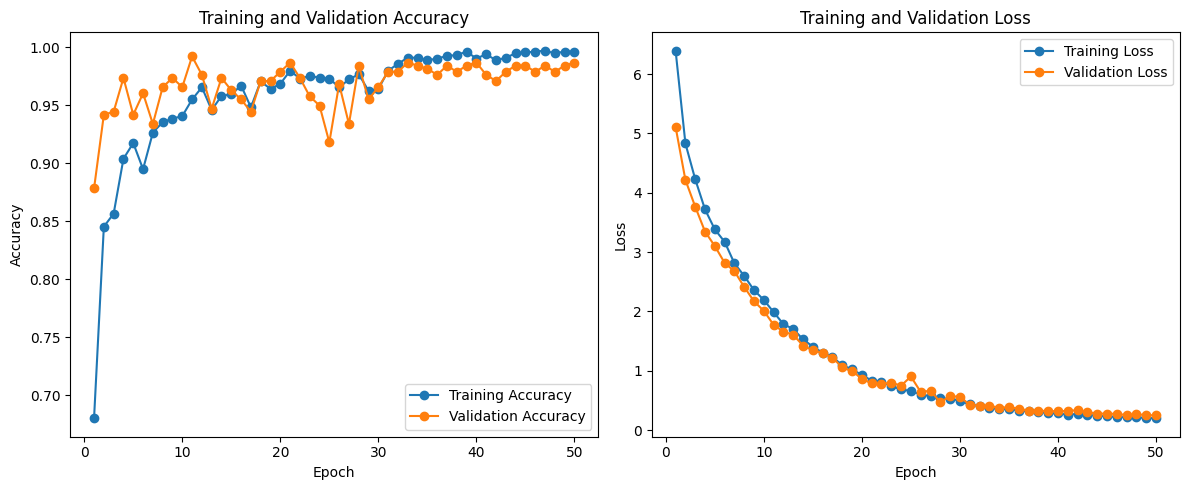

Saved model weights to /content/model_checkpoints/new_models/final_model_weights.weights.h5


In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50V2, DenseNet169
from tensorflow.keras.layers import Input, Concatenate, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import tensorflow as tf

# ================================
# 1. Set Random Seeds for Reproducibility
# ================================
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

# ================================
# 2. Define Constants and Paths
# ================================
INPUT_SHAPE = (224, 224, 3)
BATCH_SIZE = 8  # Smaller batch size for better generalization
NUM_CLASSES = 5
EPOCHS = 50
INITIAL_LR = 1e-4  # Reduced initial learning rate to avoid large initial loss
TRAIN_DIR = '/content/output_split_dataset/train'
VALID_DIR = '/content/output_split_dataset/val'
DRIVE_MODEL_PATH = '/content/model_checkpoints/new_models'

# Ensure the directory exists for saving outputs
os.makedirs(DRIVE_MODEL_PATH, exist_ok=True)

# ================================
# 3. Create Data Generators with Augmentation
# ================================
datagen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen_val = ImageDataGenerator(rescale=1./255)

train_generator = datagen_train.flow_from_directory(
    TRAIN_DIR,
    target_size=INPUT_SHAPE[:2],
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

valid_generator = datagen_val.flow_from_directory(
    VALID_DIR,
    target_size=INPUT_SHAPE[:2],
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# ================================
# 4. Build a Simplified Multi-Branch Model with Moderate Regularization
# ================================

def build_model():
    inputs = Input(shape=INPUT_SHAPE, name="main_input")

    # Instantiate only two base models to reduce complexity
    resnet_base = ResNet50V2(weights='imagenet', include_top=False, pooling='avg', name='resnet_base')
    densenet_base = DenseNet169(weights='imagenet', include_top=False, pooling='avg', name='densenet_base')

    # Pass the input through each model independently
    resnet_out = resnet_base(inputs)
    densenet_out = densenet_base(inputs)

    # Concatenate the outputs of the models
    combined = Concatenate(name='concatenate')([resnet_out, densenet_out])

    # Add fully connected layers with reduced L2 regularization and dropout
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.01), name='fc1')(combined)
    x = Dropout(0.5, name='dropout1')(x)  # Moderate dropout rate
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.01), name='fc2')(x)
    x = Dropout(0.5, name='dropout2')(x)

    output = Dense(NUM_CLASSES, activation='softmax', name='output')(x)

    # Define inputs and outputs in the final model
    model = Model(inputs=inputs, outputs=output, name='RegularizedMultiBranchModel')
    return model

# Build and compile the model
model = build_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# ================================
# 5. Training with Early Stopping and Learning Rate Reduction
# ================================
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Learning rate reduction on plateau
lr_reduction = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=valid_generator,
    callbacks=[early_stopping, lr_reduction],
    verbose=1
)

# ================================
# Plot Training and Validation Accuracy and Loss
# ================================

def plot_training_history(history):
    epochs = range(1, len(history.history['accuracy']) + 1)
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(12, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, label="Training Accuracy", marker='o')
    plt.plot(epochs, val_acc, label="Validation Accuracy", marker='o')
    plt.title("Training and Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, label="Training Loss", marker='o')
    plt.plot(epochs, val_loss, label="Validation Loss", marker='o')
    plt.title("Training and Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot the training history
plot_training_history(history)

# ================================
# Save the Model Weights
# ================================
model.save(os.path.join(DRIVE_MODEL_PATH, 'final_model_weights.weights.keras'))
print(f'Saved model weights to {os.path.join(DRIVE_MODEL_PATH, "final_model_weights.weights.h5")}')